<a href="https://www.kaggle.com/code/kavishchaudhary1003/playground-s3-e7?scriptVersionId=119988189" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd 
from tqdm import tqdm
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, IsolationForest
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix



import os
for dirname, _, filenames in os.walk('/kaggle/input/playground-series-s3e7'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/playground-series-s3e7/sample_submission.csv
/kaggle/input/playground-series-s3e7/train.csv
/kaggle/input/playground-series-s3e7/test.csv


# Competition Page
https://www.kaggle.com/competitions/playground-series-s3e7/overview

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e7/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e7/test.csv')

### Check for null and duplicates

In [3]:
train.isna().sum()
train.duplicated().sum()

0

### Summary stats

In [4]:
train.describe()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
count,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000
mean,21049.500000,1.920713,0.141093,0.884632,2.398005,0.239192,0.025249,0.428931,103.888029,2017.856295,7.593539,15.902945,0.728504,0.029192,0.019715,0.175772,104.566377,0.571734,0.392019
std,12153.367503,0.524950,0.450128,0.885693,1.427330,0.587674,0.156884,0.832605,81.069343,0.350795,2.829395,8.888582,0.633529,0.168347,0.325837,1.732121,37.139165,0.775041,0.488207
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10524.750000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,37.000000,2018.000000,6.000000,8.000000,0.000000,0.000000,0.000000,0.000000,80.000000,0.000000,0.000000
50%,21049.500000,2.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,93.000000,2018.000000,8.000000,16.000000,1.000000,0.000000,0.000000,0.000000,99.450000,0.000000,0.000000
75%,31574.250000,2.000000,0.000000,2.000000,3.000000,0.000000,0.000000,1.000000,155.000000,2018.000000,10.000000,24.000000,1.000000,0.000000,0.000000,0.000000,123.300000,1.000000,1.000000
max,42099.000000,4.000000,9.000000,7.000000,17.000000,3.000000,1.000000,6.000000,443.000000,2018.000000,12.000000,31.000000,4.000000,1.000000,13.000000,58.000000,540.000000,5.000000,1.000000


### Isolation forest to remove outliers

In [5]:
If = IsolationForest()
If.fit(train)
train['anamoly'] = If.predict(train)
train.anamoly.value_counts()
train = train[train.anamoly ==1]
train.drop(columns =['anamoly'], inplace = True)

### Reset the index

In [6]:
index = train.id
train.drop(columns = ['id'], inplace = True)
train = train.reset_index(drop = True)


### Set index for the test set

In [7]:
test.set_index('id', inplace = True)

### Separating features and target variable

In [8]:
y = train.booking_status
train.drop(columns = ['booking_status'], inplace = True)

In [9]:
for i in train.columns:
    print(train[i].value_counts())

2    28084
1     5574
3     3788
0       16
4        7
Name: no_of_adults, dtype: int64
0    34849
1     2440
2      178
4        1
9        1
Name: no_of_children, dtype: int64
0    15842
2    10977
1    10397
3      175
4       57
5       15
6        5
7        1
Name: no_of_weekend_nights, dtype: int64
2     11785
3      9574
1      7928
4      3880
5      2386
0      1469
6       198
7       120
8        58
9        32
10       22
11        6
15        4
12        4
17        2
14        1
Name: no_of_week_nights, dtype: int64
0    32139
1     3044
2     2286
Name: type_of_meal_plan, dtype: int64
0    37131
1      338
Name: required_car_parking_space, dtype: int64
0    27401
1     8661
2      824
3      319
4      243
5       18
6        3
Name: room_type_reserved, dtype: int64
1      553
0      432
56     347
6      344
122    335
      ... 
325      1
300      1
361      1
348      1
353      1
Name: lead_time, Length: 336, dtype: int64
2018    32750
2017     4719
Name: arrival_y

### Plotting the categorical variables

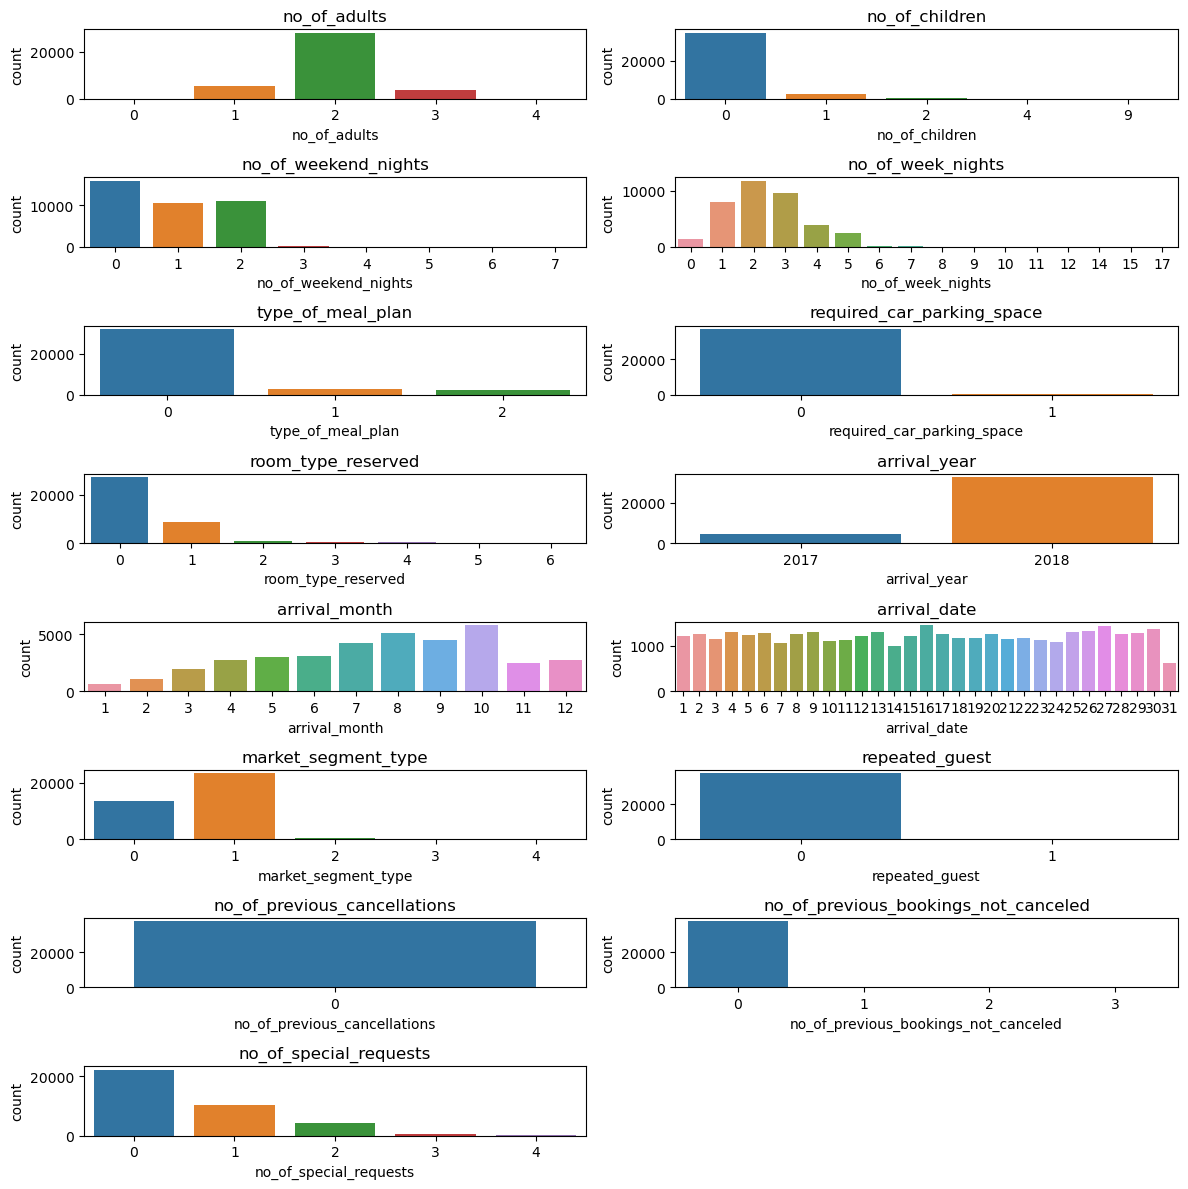

In [10]:
fig, axes = plt.subplots(nrows = 8, ncols = 2, figsize = (12,12))
for i,ax in enumerate(axes.flat):
    if i < len(['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'no_of_special_requests']):
        sns.countplot(x= train[(['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'no_of_special_requests'][i])], ax =ax )
        ax.set_title(['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'no_of_special_requests'][i])
    else:
        axes.flat[i].set_visible(False)
plt.tight_layout()
plt.show()

### Frequency encoding for the variables- train set

In [12]:
for i in ['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'no_of_special_requests']:
    train[i] = train[i].map(train[i].value_counts(normalize = True))

### Frequency encoding for the variables- test set

In [13]:
for i in ['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'no_of_special_requests']:
    test[i] = test[i].map(test[i].value_counts(normalize = True))

### Define a function for model evaluation

In [14]:
def model_eval(train, y, param, model):
    inner_cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
    outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
    scores = []
    random = RandomizedSearchCV(model, param, n_jobs = -1, cv = inner_cv, scoring = 'accuracy', random_state = 0)
    n_iter = random.n_iter
    with tqdm(total = n_iter) as pbar:
        for i in range(n_iter):
            random.set_params(n_iter = 1)
            for train_index, test_index in outer_cv.split(train, y):
                trainx, testx = train.iloc[train_index], train.iloc[test_index]
                trainy, testy = y[train_index], y[test_index]
                random.fit(trainx,trainy)
                scores.append(random.best_estimator_.score(testx, testy))
            pbar.update()
    print('Average score', np.mean(scores))
    print(random.best_params_)
                


### Decision Tree
### Randomizedsearch with nested cv
Average score 0.7969619952494063
{'min_samples_split': 60, 'max_depth': 28, 'criterion': 'entropy'}

In [ ]:
model = DecisionTreeClassifier()
param = {'criterion' : ['entropy', 'gini', 'log_loss'], 'min_samples_split': np.array(range(1, 100)), 'max_depth': np.array(range(1, 100))}
model_eval(train, y, param, model)

model = DecisionTeeClassifier(criterion = entropy, max_depth = 28, min_samples_split = 60)
model.fit(train,y)
model.score(test)

### Random Forest
### Randomizedsearch with nested cv
Average score 0.8168194774346793
{'n_estimators': 810, 'min_samples_split': 31, 'max_depth': 35, 'criterion': 'entropy'}

In [ ]:
model = RandomForestClassifier()
param = {'criterion': ['entropy', 'gini', 'log_loss'], 'min_samples_split': np.array(range(1, 100)), 'max_depth': np.array(range(1, 100)), 'n_estimators': np.array(range(100,1000, 10))}
model_eval(train,y,param, model)

In [ ]:
model = RandomForestClassifier(n_estimators = 810, min_samples_split = 31, max_depth =35, criterion = 'entropy')
model.fit(train, y)

### Extra Trees
### Randomizedsearch with nested cv
Average score 0.8040997624703087
{'n_estimators': 810, 'min_samples_split': 31, 'max_depth': 35, 'criterion': 'entropy'}

In [ ]:
model = ExtraTreesClassifier()
param = {'criterion': ['entropy', 'gini', 'log_loss'], 'min_samples_split': np.array(range(1, 100)), 'max_depth': np.array(range(1, 100)), 'n_estimators': np.array(range(100,1000, 10))}
model_eval(train,y,param, model)

In [ ]:
model = ExtraTreesClassifier(n_estimators = 810, min_samples_split = 31, max_depth =35, criterion = 'entropy')
model.fit(train,y)

### GaussianNB
### Randomizedsearch with nested cv
Average score 0.7266430473565244
{'var_smoothing': 0.0001}

In [ ]:
model = GaussianNB()
param ={'var_smoothing': np.logspace(0, -9, 100)}
model_eval(train, y, param, model)


In [ ]:
model = GaussianNB(var_smoothing = 0.0001)
model.fit(train,y)

### Support vector machine
### Randomizedsearch with nested cv
Average score 0.7251543942992873
{'kernel': 'rbf', 'gamma': 0.002335721469090121, 'C': 0.04281332398719396}

In [ ]:
model = SVC()
param= {'C': np.logspace(-6, 2, 20), 'gamma': np.logspace(-6,2,20), 'kernel': ['rbf', 'poly', 'linear'] }
model_eval(train,y,param,model)

In [ ]:
model = SVC(kernel = 'rbf',gamma = 0.0023357, C= 0.042813)
model.fit(train, y)

### BaggingClassifier
### Randomizedsearch with nested cv
Average score 0.8104014251781473
{'n_estimators': 640, 'max_features': 8}

In [ ]:
model = BaggingClassifier()
param = {'n_estimators': np.array(range(100, 1000, 10)), 'max_features': np.array(range(1, 17))}
model_eval(train, y, param, model)

In [ ]:
model = BaggingClassifier(n_estimators = 640, max_features = 8)
model.fit(train, y)

# The best model
### XGB Classifier
### Score - 82.23

In [ ]:
model = XGBClassifier(objective='binary:logistic',
                     eval_metric='error')
cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
scores = []
for train_index, test_index in cv.split(train, y):
                trainx, testx = train.iloc[train_index], train.iloc[test_index]
                trainy, testy = y[train_index], y[test_index]
                model.fit(trainx, trainy)
                scores.append(model.score(testx, testy))
print('Average score', np.mean(scores))

### LGBM Classifier
### Score - 82.04

In [ ]:
model = LGBMClassifier(verbosity = -100)
cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
scores = []
for train_index, test_index in cv.split(train, y):
                trainx, testx = train.iloc[train_index], train.iloc[test_index]
                trainy, testy = y[train_index], y[test_index]
                model.fit(trainx, trainy)
                scores.append(model.score(testx, testy))
print('Average score', np.mean(scores))

### Cat Boost 
### Score - 82.1

In [ ]:
model = CatBoostClassifier(verbose = 0)
cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
scores = []
for train_index, test_index in cv.split(train, y):
                trainx, testx = train.iloc[train_index], train.iloc[test_index]
                trainy, testy = y[train_index], y[test_index]
                model.fit(trainx, trainy)
                scores.append(model.score(testx, testy))
print('Average score', np.mean(scores))

In [ ]:
predictions = pd.DataFrame(model.predict(test), index = test.index, columns = ['booking_status'])

In [ ]:
predictions.to_csv('submission.csv', index = True)